# Data Exploration and visualization of the Ten Thousand German News Articles Dataset
In this notebook I will explore the dataset using different visualizations libraries.
I'll use the articles.csv file (must be in project root folder)

## Imports

In [21]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download as nltk_download
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import umap

In [5]:
# Only need to download the first time :
nltk_download('stopwords')
nltk_download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Loading Dataset and classes repartition

In [6]:
articles_df = pd.read_csv('articles.csv', sep=';', header = None, names = ['label','article'])

In [7]:
articles_df

,label,article
0,Etat,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,Etat,App sei nicht so angenommen worden wie geplant...
2,Etat,"'Zum Welttag der Suizidprävention ist es Zeit,..."
3,Etat,Mitarbeiter überreichten Eigentümervertretern ...
4,Etat,Service: Jobwechsel in der Kommunikationsbranc...
...,...,...
10268,Wissenschaft,Die Fundstelle in Südengland ist Unesco-Weltku...
10269,Wissenschaft,Im Team arbeitet auch ein Inspektor der sudane...
10270,Wissenschaft,Die zentrale Frage des Projekts: Siedelten Ägy...
10271,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...


First, we visualize the repartition of articles in the classes

,article
label,
Etat,668
Inland,1015
International,1511
Kultur,539
Panorama,1678
Sport,1201
Web,1677
Wirtschaft,1411
Wissenschaft,573


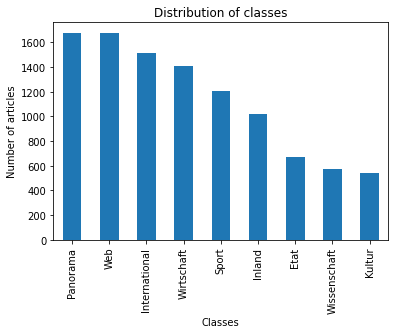

In [8]:
articles_df['label'].value_counts().plot(kind='bar', 
                                         title= 'Distribution of classes', 
                                         ylabel= 'Number of articles',
                                         xlabel= 'Classes')
articles_df.groupby(['label']).count()

We can see that classes are not balanced. So it will be important to take care of it during the train/test split (so that we have an even amount of each classes in train set and test set).

## Visualizing most frequent words in each class

First, I will remove german stopwords using NLTK library as they will most likely be the dominant words in each class and the visualization will be useless if we don't remove them. I will also lowercase the whole text so that we don't treat the same stopwords differently.

In [9]:
german_stop_words = stopwords.words('german') # getting german stopwords from NLTK (must download one time if first time using it)
# removing german stopwords and lowercasing articles and then cast them into a new column
articles_df["preprocessed_article"] = articles_df['article'].apply(lambda article :' '.join([word.lower() for word in word_tokenize(article) if word.lower() not in german_stop_words]))

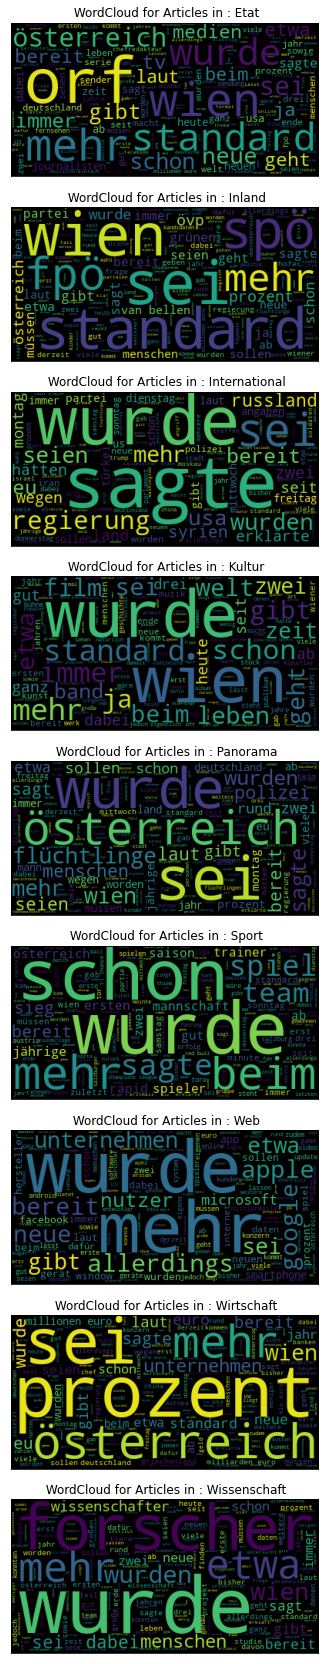

In [10]:
unique_labels = articles_df.label.unique() # array of unique labels
n_labels = len(unique_labels)# number of labels
fig, axes = plt.subplots(n_labels,1,figsize=(30,30)) # initializing one plot for each label
i = 0
for label in unique_labels: # iterating through all labels
    # Generating word cloud from joined articles in current label
    wordcloud = WordCloud().generate(' '.join(articles_df[articles_df['label']==label]['preprocessed_article'] ))
    axes[i].imshow(wordcloud)
    # Removing x and y axis because useless when visualizing word clouds
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(" WordCloud for Articles in : " + label)
    i+=1

## Using sentence embeddings to visualize classes datapoints

I will use a [Sentence-Transformer Pretrained Model](https://www.sbert.net/docs/pretrained_models.html) to embed the articles sentences and then reduce their dimensions using UMAP for visualization.
I chose one of the mutilingual models with best performance according to authors as there were no models for german specifically on sentence transformers.
You can run this step on GPU for faster encoding of articles.

In [11]:
# Embedding articles using sentence transformers
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device='cuda') # run on CUDA for faster inference
embeddings = model.encode(articles_df["preprocessed_article"], show_progress_bar=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/322 [00:00<?, ?it/s]

In [12]:
# Doing dimension reduction with UMAP
umap_embedding = umap.UMAP(n_neighbors = 30, random_state=42).fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [28]:
ord = OrdinalEncoder()
num_labels = ord.fit_transform(articles_df['label'].values.reshape(len(articles_df['label']),1))
print("CLASS MAPPING :")
for i in range(n_labels):
  print(f"{i} --> {ord.inverse_transform(np.array([[i]]))[0]}")

CLASS MAPPING :
0 --> ['Etat']
1 --> ['Inland']
2 --> ['International']
3 --> ['Kultur']
4 --> ['Panorama']
5 --> ['Sport']
6 --> ['Web']
7 --> ['Wirtschaft']
8 --> ['Wissenschaft']


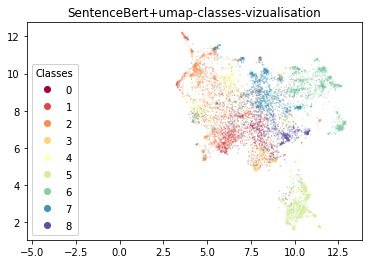

In [19]:
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding.T[0], umap_embedding.T[1], s=0.03, c=num_labels, cmap='Spectral')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.title("SentenceBert + umap-classes-vizualisation")
plt.show()

We can see that some classes are isolated from the others like class n°5 (Sport) or class n° 6 (Web) and others are a little bit mixed together (so they will probably be harder to classify). Indeed, as shown in the word clouds, some classes share the same most frequent words so some are more similar than others. Globally the colors representing the classes seems more or less clustered together so overall, after training, the model should perform correctly.